# Redes Convolucionales con pocos datos

In [2]:
import keras
keras.__version__

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

Es común oir que Deep Learning solo es válido cuando tenemos una cantidad inmensa de datos, y aunque es una afirmación que es válida parcialmente (ya que extrae características interesantes de los datos sin necesidad de acudir a ingeniería manual), podemos encontrar situaciones en las que con unos cientos de datos es suficiente para extraer un modelo (pequeño) interesante si el problema presenta suficiente regularidad.

## Entrenando una CNN con pocos datos

Tener que entrenar un modelo de clasificación sobre pocos datos es una situación muy común. Aunque, por supuesto, qué consideramos pocos datos es algo que depende del problema y del contexto, y puede ir desde unos cuantos cientos hasta decenas de miles cuando el problema es más complicado.

Para hacer las pruebas de este caso vamos a construir un pequeño  clasificador de imágenes para distinguir entre "perros" y "gatos". El dataset que usaremos está extraído de una competición de Kaggle en el que los datos los proporciona Microsoft. Nosotros usaremos solo una sección del dataset que ellos proporcionan, con un total de 4,000 imágenes (2,000 de cada tipo), y donde dividiremos en 2,000/1,000/1,000 de entrenamiento/validación/test completamente balanceados.

Vamos a comenzar con una versión muy sencilla de una red convolucional que entrenaremos con las 2,000 imágenes que tenemos en el conjunto de entrenamiento, sin hacer ningún tipo de regularización, solo con el fin de obtener un modelo base sobre el que medir posteriormente las mejoras que introduzcamos. Con esta primera versión, sin ningún tipo de mejora adicional, somos capaces de alcanzar ~70% de accuracy. Veremos que en este momento nuestro principal problema es el de sobreajuste, debido principalmente a la ausencia de suficientes datos para entrenar, por lo que tendremos que introducir alguna técnica que nos permita aliviar este problema. 

Como indicamos en el tema de Regularización, debido a que estamos en un problema de imágenes, es común hacer uso de la técnica de **Data Augmentation**, que junto con una capa de dropout permitirá alcanzar un rendimiento que rondará el 82% (una mejora del 12% absoluto).

## El Dataset

En la carpeta `CatsDogs` puedes encontrar el conjunto inicial de 4,000 imágenes al que hacíamos alusión anteriormente. Dentro de esa carpeta ya están separadas las imágenes en los diversos conjuntos de entrenamiento, validación y test que usaremos, así como las carpetas `Cats` y `Dogs` con las imágenes originales..

El código que permite construir los datasets a partir del original se muestra a continuación, pero solo a título informativo, porque para el curso ya se proporcionan construidos (así que no lo ejecutes para no repetir el trabajo ya realizado):

In [7]:
import os, shutil
os.getcwd()

'/home/dasolma/DL/4. Redes Convolucionales'

In [10]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '../../data/cat_dogs'

# The directory where we will
# store our smaller dataset
base_dir = '../../data/cat_dogs'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(base_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

original_dataset_dir = os.path.join(original_dataset_dir, 'train_original')
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Puedes comprobar que los números que indicábamos son los correctos:


In [30]:
print('Nº imágenes entrenamiento Gatos:', len(os.listdir(train_cats_dir)))

Nº imágenes entrenamiento Gatos: 1000


In [31]:
print('Nº imágenes entrenamiento Perros:', len(os.listdir(train_dogs_dir)))

Nº imágenes entrenamiento Perros: 1000


In [32]:
print('Nº imágenes validación Gatos:', len(os.listdir(validation_cats_dir)))

Nº imágenes validación Gatos: 500


In [33]:
print('Nº imágenes validación Perros:', len(os.listdir(validation_dogs_dir)))

Nº imágenes validación Perros: 500


In [34]:
print('Nº imágenes test Gatos:', len(os.listdir(test_cats_dir)))

Nº imágenes test Gatos: 500


In [35]:
print('Nº imágenes test Perros:', len(os.listdir(test_dogs_dir)))

Nº imágenes test Perros: 500



Como el conjunto está completamente balanceado, la precisión de clasficiación (binaria, en este caso) es una buena medida del rendimiento del modelo.


## Construyendo el modelo

Vamos a reutilizar la estructura de Red Convolucional que vimos en el ejemplo anterior (MNIST), que constaba de: una pila alternada de capas `layer_conv_2d()` (con activación `relu`) y capas `layer_max_pooling_2d()`.

Como las imágenes de este problema son más grandes y el problema es más complejo, haremos la red más grande con una capa más de cada tipo, por lo que aumentaremos la capacidad de la red y a la vez reduciremos el tamaño de salida de la última capa, que habrá que aplanar de forma similar con `layer_flatten()`. Como comenzamos con imágenes de tamaño 150x150 (es arbitrario), acabaremos con un mapa de características de 7x7 justo como entrada a la capa `layer_flatten()`.

A medida que la profundidad del mapa de características aumente (de 32 a 128), el tamaño del mismo disminuye (de 148x148 a 7x7), un patrón que es habitual en la mayoría de redes CNN.

Como el problema es de clasificación binaria, acabamos la red con una capa `layer_dense()` de una sola unidad y con activación `sigmoid`, que codificará la probabilidad de que la red esté mirando un elemento de cada una de las clases.


In [42]:
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model

CNN = models.Sequential()
CNN.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(512, activation='relu'))
CNN.add(layers.Dense(1, activation='sigmoid'))

plot_model(CNN, to_file='CNNCatsDogs_plot.png', show_shapes=True, show_layer_names=True)

Mira la arquitectura construida:
![](CNNCatsDogs_plot.png)

In [43]:
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Para el paso de compilación haremos uso de las propiedades habituales:


In [44]:
from keras import optimizers

CNN.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Preprocesamiento de los datos

Como ya sabemos, los datos deben ser formateados para ser convertidos en tensores de punto flotante para alimentar la red, pero lo que tenemos son ficheros JPEG, así que los pasos para convertirlos son:

* Leer los ficheros de imágenes.
* Decodificar JPEG en una matriz de RGB.
* Convertir la matriz en tensores de punto flotante.
* Re-escalar los valores de `[0,255]` a `[0, 1]`.

Aunque puede parece algo tedioso, Keras proporciona utilidades para llevar a cabo este tipo de acciones, que son muy comunes. En particular, incluye la función `image_data_generator()`, que automáticamente convierte ficheros de imágenes en tensores preprocesados:

**NOTA: Las funciones anteriores necesitan la librería `Pillow` de Python.**

In [45]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Este proceso ha generado un paquete de imágenes de tamaño `(20, 150, 150, 3)` (20 imágenes de 150x150 con 3 canales) y un paquete de etiquetas de tamaño `(20)`).


In [46]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Se debe tener en cuenta que el generador crea los batches de imágenes indefinidamente, haciendo un loop sobre el conjunto de imágenes de la carpeta. En realidad, estas imágenes no se procesan previamente, sino que se crea un batch cuando el entrenamiento lo requiere. Esta característica  hará que el proceso de entrenamiento tenga ligeras diferencias a las vistas anteriormente.

Durante el entrenamiento debemos usar el generador anterior, y para eso Keras proporciona una variante de la función `fit` llamada `fit_generator`, que espera como primer argumento un generador que producirá batches de entradas y etiquetas de forma indefinida, al estilo del que hemos escrito antes. 

Como los datos se generan sin fin, el generador necesita saber cuántas muestras tomar para cada epoch, para lo que hace uso del argumento `steps_per_epoch`: tras haber tomado `steps_per_epoch` batches del generador (es decir, tras haber ejecutado `steps_per_epoch` pasos del optimizador) el proceso de entrenamiento pasará a la siguiente epoch. 

Cuando se usa `fit_generator`, se puede pasar un argumento `validation_data` tal y como se hace con `fit`. Este argumento puede ser un generador o una lista de arrays. Si pasas un generador, funcionará indefinidamente, por lo que tendrás que especificar también el argumento `validation_steps`, que indica cuántos batches crear para la evaluación.

In [47]:
entrenamiento = CNN.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6859 - acc: 0.5365 - val_loss: 0.6641 - val_acc: 0.5910
Epoch 2/30
100/100 [==============================] - 6s 55ms/step - loss: 0.6502 - acc: 0.6185 - val_loss: 0.6257 - val_acc: 0.6430
Epoch 3/30
100/100 [==============================] - 5s 55ms/step - loss: 0.6031 - acc: 0.6805 - val_loss: 0.6239 - val_acc: 0.6600
Epoch 4/30
100/100 [==============================] - 5s 54ms/step - loss: 0.5645 - acc: 0.7190 - val_loss: 0.6289 - val_acc: 0.6520
Epoch 5/30
100/100 [==============================] - 6s 55ms/step - loss: 0.5316 - acc: 0.7425 - val_loss: 0.5963 - val_acc: 0.6660
Epoch 6/30
100/100 [==============================] - 5s 54ms/step - loss: 0.5078 - acc: 0.7545 - val_loss: 0.5827 - val_acc: 0.6920
Epoch 7/30
100/100 [==============================] - 5s 55ms/step - loss: 0.4924 - acc: 0.7570 - val_loss: 0.6069 - val_acc: 0.6780
Epoch 8/30
100/100 [==============================] - 5s 53ms/step - 

Es una buena práctica grabar el modelo tras el entrenamiento, sobre todo si puede consumir un tiempo excesivo:


In [48]:
CNN.save('cats_and_dogs_1.h5')

Representemos la pérdida y precisión experimentada en el proceso de entrenamiento para poder analizar cómo se comporta el modelo:


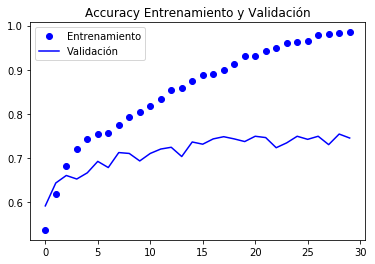

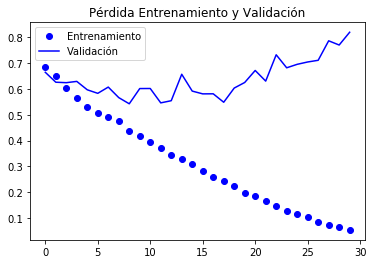

In [52]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = entrenamiento.history['acc']
val_acc = entrenamiento.history['val_acc']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida Entrenamiento y Validación')
plt.legend()

plt.show()

Según vimos en el tema anterior, estas curvas son características de un aprendizaje con sobreajuste: la precisión de entrenamiento se incrementa linealmente con el tiempo, hasta alcanzar valores cercanos al 100%, mientras que la de validación se estanca en el 70-75%. La pérdida de validación alcanza el mínimo tras unas 5 epochs, mientras que la de entrenamiento continúa cayendo hasta que prácticamente alcanza el valor 0.

Como tenemos relativamente pocos ejemplos de entrenamiento, el sobreajuste se convierte en nuestro principal problema. Ya hemos visto algunas técnicas para mitigar este efecto, como son dropout y regularization, pero en esta ocasión comprobaremos cómo funciona **Data Augmentation**, que suele dar buenos resultados al trabajar con imágenes.

## Usando Data Augmentation

Con una cantidad inifinita de datos, mostrando todas las posibles opciones existentes, el modelo nunca se sobreajustaría. _Data augmentation_ intenta simuar esta situación ideal generando más datos de entrenamiento a partir de los ejemplos disponibles por medio de la aplicación de transformaciones aleatorias que generan imágenes similares. El objetivo es hacer que nuestro modelo no vea dos veces la misma imagen exacta, lo que ayuda a que el modelo generalice mejor.

En Keras esto se puede hacer configurando un conjunto de transformaciones aleatorias para que sean ejecutadas sobre las imágenes que lee el generador `image_data_generator()`. Veamos un ejemplo que añade más opciones a las ya vistas:

In [53]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Éstas solo son algunas de las opciones disponibles (en la documentación de Keras puedes encontrar más). Veamos cómo funcionan sobre alguna imagen concreta de nuestro dataset:

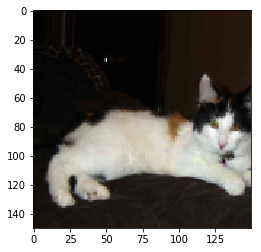

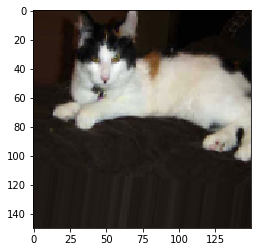

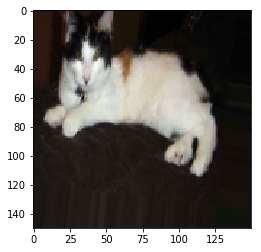

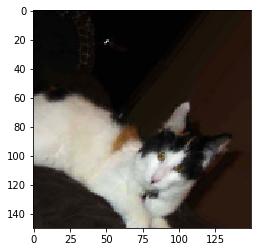

In [54]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Si entrenamos una red usando esta nueva configuración con datos aumentados, ésta no verá dos veces la misma entrada, aunque evidentemente las entradas estarán altamente correlacionadas porque provienen de unas cuantas imágenes originales. Como consecuencia, no tiene porqué ser suficiente para eliminar el sobreajuste, y por esa razón intercalaremos también una capa intermedia de dropout justo antes de la capa clasificadora densa:

In [56]:
CNN_DA = models.Sequential()
CNN_DA.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_DA.add(layers.MaxPooling2D((2, 2)))
CNN_DA.add(layers.Flatten())
CNN_DA.add(layers.Dropout(0.5))
CNN_DA.add(layers.Dense(512, activation='relu'))
CNN_DA.add(layers.Dense(1, activation='sigmoid'))

CNN_DA.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

plot_model(CNN_DA, to_file='CNNCatsDogsDA_plot.png', show_shapes=True, show_layer_names=True)

![](CNNCatsDogsDA_plot.png)
Vamos a entrenar ahora la red usando estas dos características nuevas:


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

entrenamiento_DA = CNN_DA.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 18s 185ms/step - loss: 0.6948 - acc: 0.5125 - val_loss: 0.6840 - val_acc: 0.5089
Epoch 2/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6785 - acc: 0.5725 - val_loss: 0.6565 - val_acc: 0.6180
Epoch 3/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6656 - acc: 0.5894 - val_loss: 0.6438 - val_acc: 0.6187
Epoch 4/100
100/100 [==============================] - 17s 167ms/step - loss: 0.6495 - acc: 0.6122 - val_loss: 0.6175 - val_acc: 0.6256
Epoch 5/100
100/100 [==============================] - 17s 167ms/step - loss: 0.6373 - acc: 0.6237 - val_loss: 0.6106 - val_acc: 0.6605
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 0.6155 - acc: 0.6506 - val_loss: 0.6108 - val_acc: 0.6618
Epoch 7/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6096 - acc: 0.6628 -

Grabemos nuestro modelo, que usaremos un poco más adelante, y así no tenemos que volver a entrenarlo (en este caso, al haber sido 100 epochs, el tiempo que tarda una CPU estándar ya empiezan a ser altos):


In [26]:
CNN_DA.save('cats_and_dogs_DA.h5')

Y representemos los resultados para compararlos con el modelo básico anterior:


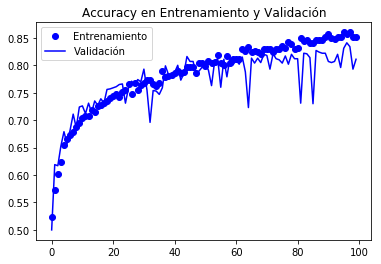

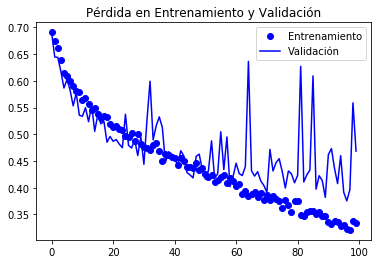

In [27]:
ent_acc = entrenamiento_DA.history['acc']
val_acc = entrenamiento_DA.history['val_acc']
ent_loss = entrenamiento_DA.history['loss']
val_loss = entrenamiento_DA.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

Según la información que dan estas gráficas, gracias a la combinación de data augmentation y dropout ya no tenemos sobreajuste. Ambas curvas se mantienen cerca, y ahora alcanzamos una precisión del 82%, lo que supone una mejora considerable respecto del modelo no regularizado.

Ajustando las técnicas de regularización y afinando los parámetros de la red (el número de filtros por capa y el número de capas), podriamos subir quizás hasta un 86-87% de precisión, pero será muy difícil superar este punto entrenando nuestro modelo con tan pocos datos desde cero. Hemos de buscar soluciones alternativas...